In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)

Using GPU: /physical_device:GPU:0


In [6]:
import pandas as pd

file_path = 'city_hour.csv'
data = pd.read_csv(file_path)

data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707875 entries, 0 to 707874
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   City        707875 non-null  object 
 1   Datetime    707875 non-null  object 
 2   PM2.5       562787 non-null  float64
 3   PM10        411138 non-null  float64
 4   NO          591243 non-null  float64
 5   NO2         590753 non-null  float64
 6   NOx         584651 non-null  float64
 7   NH3         435333 non-null  float64
 8   CO          621358 non-null  float64
 9   SO2         577502 non-null  float64
 10  O3          578667 non-null  float64
 11  Benzene     544229 non-null  float64
 12  Toluene     487268 non-null  float64
 13  Xylene      252046 non-null  float64
 14  AQI         578795 non-null  float64
 15  AQI_Bucket  578795 non-null  object 
dtypes: float64(13), object(3)
memory usage: 86.4+ MB


(        City             Datetime  PM2.5  PM10    NO    NO2    NOx  NH3    CO  \
 0  Ahmedabad  2015-01-01 01:00:00    NaN   NaN  1.00  40.01  36.37  NaN  1.00   
 1  Ahmedabad  2015-01-01 02:00:00    NaN   NaN  0.02  27.75  19.73  NaN  0.02   
 2  Ahmedabad  2015-01-01 03:00:00    NaN   NaN  0.08  19.32  11.08  NaN  0.08   
 3  Ahmedabad  2015-01-01 04:00:00    NaN   NaN  0.30  16.45   9.20  NaN  0.30   
 4  Ahmedabad  2015-01-01 05:00:00    NaN   NaN  0.12  14.90   7.85  NaN  0.12   
 
       SO2      O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
 0  122.07     NaN      0.0      0.0     0.0  NaN        NaN  
 1   85.90     NaN      0.0      0.0     0.0  NaN        NaN  
 2   52.83     NaN      0.0      0.0     0.0  NaN        NaN  
 3   39.53  153.58      0.0      0.0     0.0  NaN        NaN  
 4   32.63     NaN      0.0      0.0     0.0  NaN        NaN  ,
 None)

In [7]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

data.fillna(method='ffill', inplace=True)

df_cleaned = data.drop(columns=['City', 'AQI_Bucket'])

df_cleaned.isnull().sum(), df_cleaned.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_1972\1232942512.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


(PM2.5        665
 PM10       38274
 NO             0
 NO2            0
 NOx            0
 NH3        48192
 CO             0
 SO2            0
 O3             3
 Benzene        0
 Toluene        0
 Xylene         0
 AQI          680
 dtype: int64,
                      PM2.5  PM10    NO    NO2    NOx  NH3    CO     SO2  \
 Datetime                                                                  
 2015-01-01 01:00:00    NaN   NaN  1.00  40.01  36.37  NaN  1.00  122.07   
 2015-01-01 02:00:00    NaN   NaN  0.02  27.75  19.73  NaN  0.02   85.90   
 2015-01-01 03:00:00    NaN   NaN  0.08  19.32  11.08  NaN  0.08   52.83   
 2015-01-01 04:00:00    NaN   NaN  0.30  16.45   9.20  NaN  0.30   39.53   
 2015-01-01 05:00:00    NaN   NaN  0.12  14.90   7.85  NaN  0.12   32.63   
 
                          O3  Benzene  Toluene  Xylene  AQI  
 Datetime                                                    
 2015-01-01 01:00:00     NaN      0.0      0.0     0.0  NaN  
 2015-01-01 02:00:00     NaN   

In [12]:
df_cleaned.fillna(df_cleaned.median(), inplace=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned)

df_scaled = pd.DataFrame(scaled_data, columns=df_cleaned.columns, index=df_cleaned.index)

df_scaled.head(100)


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
Datetime,,,,,,,,,,,,,
2015-01-01 01:00:00,0.044491,0.072371,0.00198,0.080080,0.072943,0.025722,0.002006,0.610453,0.053677,0.000000,0.000000,0.00000,0.03296
2015-01-01 02:00:00,0.044491,0.072371,0.00002,0.055536,0.039570,0.025722,0.000040,0.429557,0.053677,0.000000,0.000000,0.00000,0.03296
2015-01-01 03:00:00,0.044491,0.072371,0.00014,0.038659,0.022222,0.025722,0.000160,0.264166,0.053677,0.000000,0.000000,0.00000,0.03296
2015-01-01 04:00:00,0.044491,0.072371,0.00058,0.032913,0.018451,0.025722,0.000602,0.197649,0.308615,0.000000,0.000000,0.00000,0.03296
2015-01-01 05:00:00,0.044491,0.072371,0.00022,0.029810,0.015744,0.025722,0.000241,0.163141,0.308615,0.000000,0.000000,0.00000,0.03296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-05 00:00:00,0.044491,0.072371,0.00038,0.030911,0.027316,0.025722,0.000401,0.124131,0.085147,0.006385,0.014057,0.00000,0.03296
2015-01-05 01:00:00,0.044491,0.072371,0.00038,0.034394,0.025030,0.025722,0.000401,0.338185,0.074918,0.005481,0.014417,0.00166,0.03296
2015-01-05 02:00:00,0.044491,0.072371,0.00038,0.028729,0.017088,0.025722,0.000401,0.163341,0.076767,0.001245,0.006748,0.00000,0.03296


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 24 
batch_size = 64
learning_rate = 0.0001
epochs = 75

data_array = df_scaled.values

X, y = create_sequences(data_array, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(y.shape[1])
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame with actual vs predicted values
results_df = pd.DataFrame(
    scaler.inverse_transform(predictions), 
    columns=df_cleaned.columns,
    index=df_scaled.index[train_size+sequence_length:]
)
results_df = pd.concat([
    results_df,
    pd.DataFrame(
        scaler.inverse_transform(y_test),
        columns=[f'actual_{col}' for col in df_cleaned.columns],
        index=df_scaled.index[train_size+sequence_length:]
    )
], axis=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           72704     
_________________________________________________________________
dropout (Dropout)            (None, 24, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 24, 128)           98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 13)                4

C:\Users\Admin\AppData\Local\Temp\ipykernel_1972\429460378.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()



=== Model Performance Metrics ===

Feature 1 Metrics:
MSE: 0.0011
RMSE: 0.0339
MAE: 0.0115
R² Score: 0.8315
Correlation: 0.9124

Feature 2 Metrics:
MSE: 0.0008
RMSE: 0.0285
MAE: 0.0123
R² Score: 0.8986
Correlation: 0.9492

Feature 3 Metrics:
MSE: 0.0012
RMSE: 0.0341
MAE: 0.0119
R² Score: 0.7449
Correlation: 0.8674

Feature 4 Metrics:
MSE: 0.0004
RMSE: 0.0195
MAE: 0.0099
R² Score: 0.8808
Correlation: 0.9407

Feature 5 Metrics:
MSE: 0.0011
RMSE: 0.0327
MAE: 0.0132
R² Score: 0.8214
Correlation: 0.9067

Feature 6 Metrics:
MSE: 0.0001
RMSE: 0.0084
MAE: 0.0043
R² Score: 0.8186
Correlation: 0.9124

Feature 7 Metrics:
MSE: 0.0000
RMSE: 0.0052
MAE: 0.0030
R² Score: -3.8297
Correlation: 0.3981

Feature 8 Metrics:
MSE: 0.0016
RMSE: 0.0401
MAE: 0.0175
R² Score: 0.7982
Correlation: 0.8953

Feature 9 Metrics:
MSE: 0.0005
RMSE: 0.0224
MAE: 0.0130
R² Score: 0.8933
Correlation: 0.9487

Feature 10 Metrics:
MSE: 0.0002
RMSE: 0.0141
MAE: 0.0027
R² Score: 0.9376
Correlation: 0.9748

Feature 11 Metrics:
MS

c:\Users\Admin\miniconda3\envs\tensor_gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


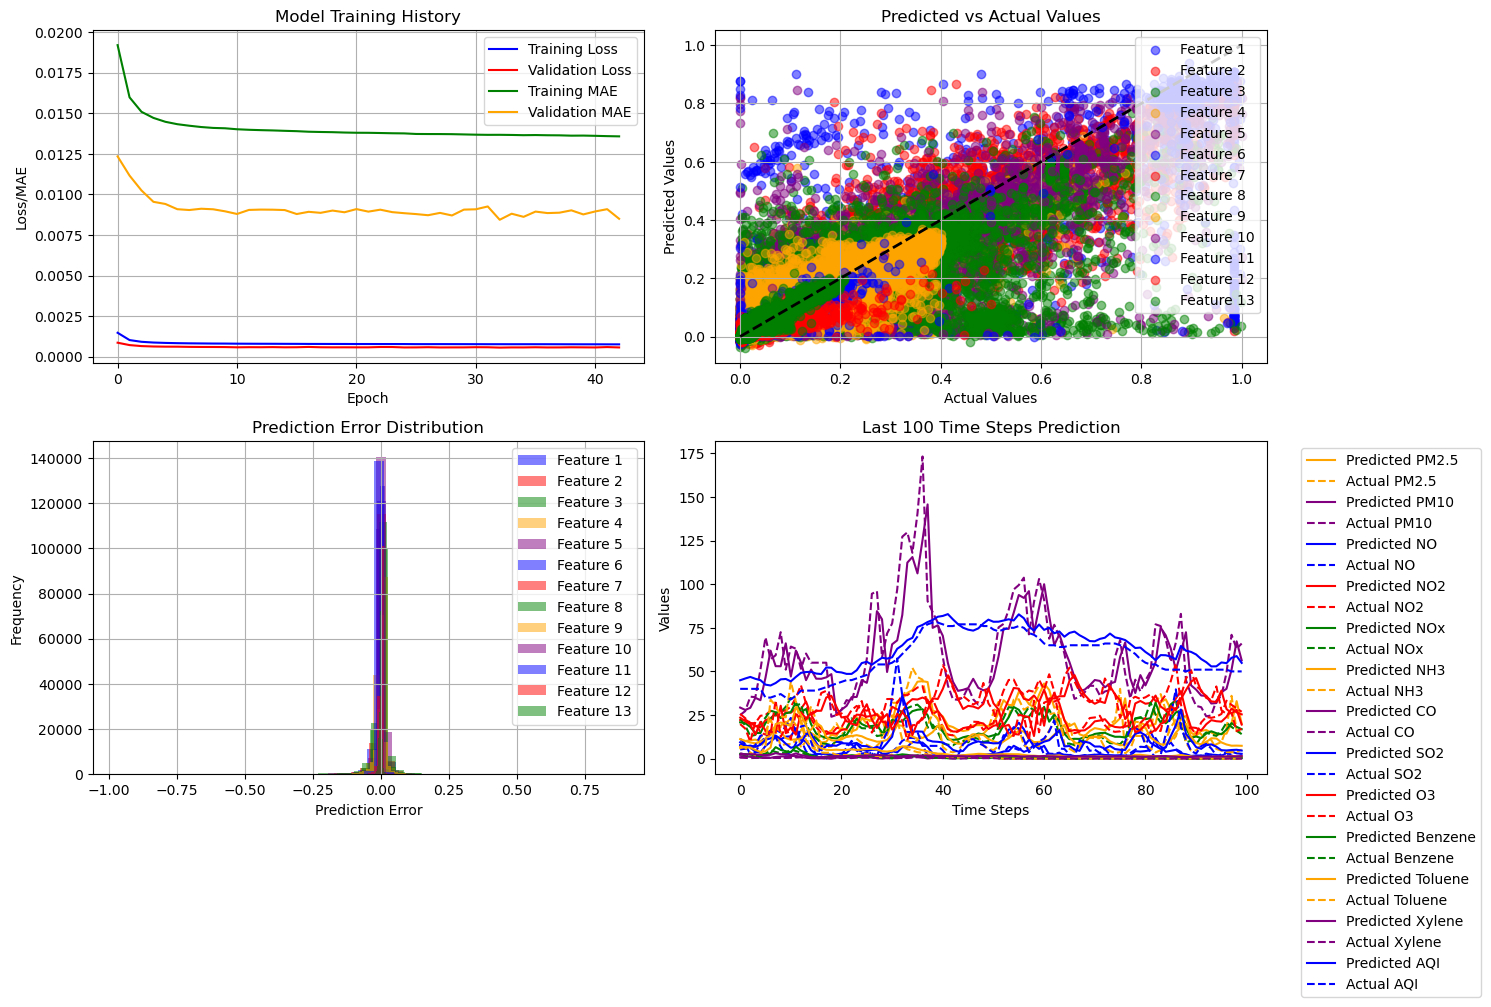

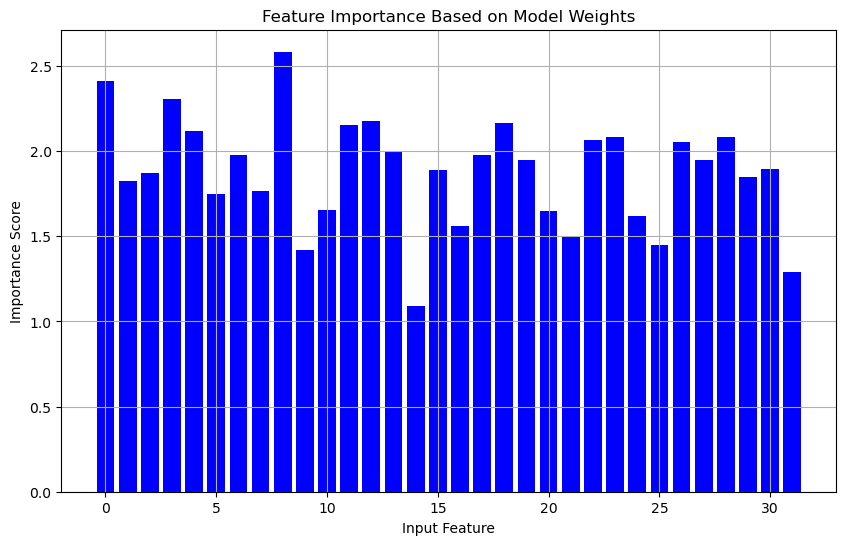

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

def evaluate_and_visualize_model(history, results_df, predictions, y_test):
    
    plt.style.use('default')
    
    # 1. Training History Plot
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(221)
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.plot(history.history['mae'], label='Training MAE', color='green')
    ax1.plot(history.history['val_mae'], label='Validation MAE', color='orange')
    ax1.set_title('Model Training History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss/MAE')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Predicted vs Actual Scatter Plot
    ax2 = fig.add_subplot(222)
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
    for i in range(predictions.shape[1]):
        ax2.scatter(y_test[:, i], predictions[:, i], alpha=0.5, 
                   color=colors[i % len(colors)], label=f'Feature {i+1}')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'k--', lw=2)
    ax2.set_title('Predicted vs Actual Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Prediction Error Distribution
    ax3 = fig.add_subplot(223)
    errors = predictions - y_test
    for i in range(errors.shape[1]):
        # Using histogram instead of kernel density estimation
        ax3.hist(errors[:, i], bins=50, alpha=0.5, 
                 color=colors[i % len(colors)], label=f'Feature {i+1}')
    ax3.set_title('Prediction Error Distribution')
    ax3.set_xlabel('Prediction Error')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True)
    
    # 4. Time Series Plot
    ax4 = fig.add_subplot(224)
    for idx, col in enumerate(results_df.columns):
        if col.startswith('actual_'):
            feature_name = col.replace('actual_', '')
            color = colors[idx % len(colors)]
            ax4.plot(range(100), results_df[feature_name][-100:], 
                    color=color, label=f'Predicted {feature_name}')
            ax4.plot(range(100), results_df[col][-100:], 
                    '--', color=color, label=f'Actual {feature_name}')
    ax4.set_title('Last 100 Time Steps Prediction')
    ax4.set_xlabel('Time Steps')
    ax4.set_ylabel('Values')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Calculate and print detailed metrics
    print("\n=== Model Performance Metrics ===")
    
    metrics_dict = {}
    for i in range(predictions.shape[1]):
        feature_metrics = {
            'MSE': mean_squared_error(y_test[:, i], predictions[:, i]),
            'RMSE': np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i])),
            'MAE': mean_absolute_error(y_test[:, i], predictions[:, i]),
            'R2': r2_score(y_test[:, i], predictions[:, i]),
            'Correlation': stats.pearsonr(y_test[:, i], predictions[:, i])[0]
        }
        metrics_dict[f'Feature_{i+1}'] = feature_metrics
        
        print(f"\nFeature {i+1} Metrics:")
        print(f"MSE: {feature_metrics['MSE']:.4f}")
        print(f"RMSE: {feature_metrics['RMSE']:.4f}")
        print(f"MAE: {feature_metrics['MAE']:.4f}")
        print(f"R² Score: {feature_metrics['R2']:.4f}")
        print(f"Correlation: {feature_metrics['Correlation']:.4f}")
    
    # Create metrics summary DataFrame
    metrics_df = pd.DataFrame(metrics_dict).round(4)
    print("\n=== Metrics Summary ===")
    print(metrics_df)
    
    # Additional model statistics
    print("\n=== Additional Statistics ===")
    print(f"Total Parameters: {model.count_params():,}")
    print(f"Training History Length: {len(history.history['loss'])} epochs")
    
    # Learning rate analysis
    if 'lr' in history.history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['lr'])
        plt.title('Learning Rate Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        plt.show()
    
    # Feature Importance Plot
    plt.figure(figsize=(10, 6))
    feature_importance = np.sum(np.abs(model.layers[-1].get_weights()[0]), axis=1)
    plt.bar(range(len(feature_importance)), feature_importance, color='blue')
    plt.title('Feature Importance Based on Model Weights')
    plt.xlabel('Input Feature')
    plt.ylabel('Importance Score')
    plt.grid(True)
    plt.show()
    
    return metrics_df

# Call the evaluation function
metrics_df = evaluate_and_visualize_model(
    history=history,
    results_df=results_df,
    predictions=predictions,
    y_test=y_test
)

# Save the metrics to a CSV file (optional)
metrics_df.to_csv('model_metrics.csv')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate overall model metrics
def calculate_overall_metrics(y_test, predictions):
    """Calculate overall model metrics across all features"""
    
    # Flatten arrays if multi-dimensional
    y_test_flat = y_test.reshape(-1)
    predictions_flat = predictions.reshape(-1)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_flat, predictions_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, predictions_flat)
    r2 = r2_score(y_test_flat, predictions_flat)
    
    # Calculate accuracy (as 1 - normalized RMSE)
    y_range = np.max(y_test_flat) - np.min(y_test_flat)
    accuracy = max(0, 100 * (1 - rmse/y_range))  # As percentage
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

def plot_accuracy(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

metrics = calculate_overall_metrics(y_test, predictions)
print(f"Mean Squared Error (MSE): {metrics['MSE']:.4f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"R² Score: {metrics['R2']:.4f}")

plot_accuracy(history)

NameError: name 'y_test' is not defined